In [36]:
%matplotlib notebook
import utils; reload(utils)
from utils import *

In [37]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [38]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D 
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [39]:
#Lets build a linear model using Dense model without any non linear activation

x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [40]:
x[:4]

array([[ 0.292 ,  0.9831],
       [ 0.131 ,  0.3666],
       [ 0.406 ,  0.7003],
       [ 0.9039,  0.0894]])

In [41]:
y[:4]

array([ 4.5332,  2.3616,  3.9129,  3.0758])

In [42]:
lm = Sequential()
lm.add(Dense(1, input_shape=[2, ]))
lm.compile(optimizer=SGD(lr=0.01), loss = 'mse')

In [43]:
lm.evaluate(x, y, verbose=0) #evaluation of the loss function

10.054136276245117

In [44]:
lm.fit(x, y, nb_epoch = 5, batch_size=1) 

Epoch 1/5
30/30 [==============================] - 0s - loss: 4.7073      
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.7990     

In [45]:
lm.evaluate(x, y, verbose=0) #reduction in loss 

0.10585472732782364

In [46]:
lm.get_weights()

[array([[ 1.7068],
        [ 1.691 ]], dtype=float32), array([ 1.8681], dtype=float32)]

In [47]:
path = "./data/fastai/redux/sample/"
model_path = path+'models/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [48]:
batch_size = 4

In [49]:
from Vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [50]:
batches = get_batches(path+'train', shuffle=False, batch_size =1 )
val_batches = get_batches(path+'valid', shuffle=False, batch_size = 1)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [51]:
train_data = get_data(path+'train')
val_data = get_data(path+'valid')

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [52]:
train_data.shape

(200, 3, 224, 224)

In [53]:
val_data.shape

(50, 3, 224, 224)

In [63]:
#keras returns classes as single columns needs to convert it to onehot
def one_hot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

In [65]:
val_classes = val_batches.classes
train_classes = batches.classes
val_labels = one_hot(val_classes)
train_labels = one_hot(batches.classes)

In [66]:
train_labels.shape

(200, 2)

In [67]:
train_classes.shape

(200,)

In [68]:
train_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [69]:
train_features = model.predict(train_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [70]:
train_features.shape

(200, 1000)

In [71]:
save_array(model_path+"train_last_layer_features.bc", train_features)
save_array(model_path+"valid_last_layer_features.bc", val_features)

In [73]:
train_features = load_array(model_path+"train_last_layer_features.bc")
val_features = load_array(model_path+"valid_last_layer_features.bc")

In [77]:
lm = Sequential([Dense(2, activation='softmax', input_shape=(1000,))])
lm.compile(optimizer = RMSprop(lr=0.1), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [78]:
#batch_size = 64
batch_size = 4

In [79]:
#Fit the model with saved weights from vgg model
lm.fit(train_features, train_labels, nb_epoch=2, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/2
200/200 [==============================] - 1s - loss: 0.5027 - acc: 0.7950 - val_loss: 0.4941 - val_acc: 0.7800

In [80]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_19 (Dense)                 (None, 2)             2002        dense_input_9[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [82]:
#see some correct and incorrect predictions at random 

preds = lm.predict_classes(val_features, batch_size=batch_size)
probs = lm.predict_proba(val_features, batch_size, batch_size)[:,0]
probs[:8]

44/50 [=========================>....] - ETA: 0s32/50 [==================>...........] - ETA: 0s

array([ 0.2459,  0.8992,  0.598 ,  0.572 ,  0.9912,  0.9489,  0.2222,  0.7926], dtype=float32)

In [83]:
filenames = val_batches.filenames #get the filename so that we can see images

In [92]:
n_view = 4
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/' + filenames[i]) for i in idx], titles=titles)

<IPython.core.display.Javascript object>


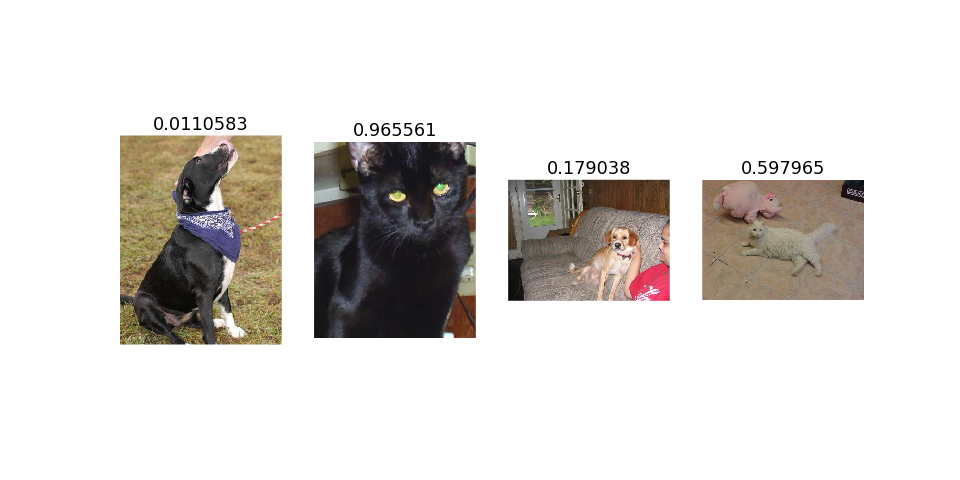

In [93]:
correct = np.where(preds == val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

<IPython.core.display.Javascript object>


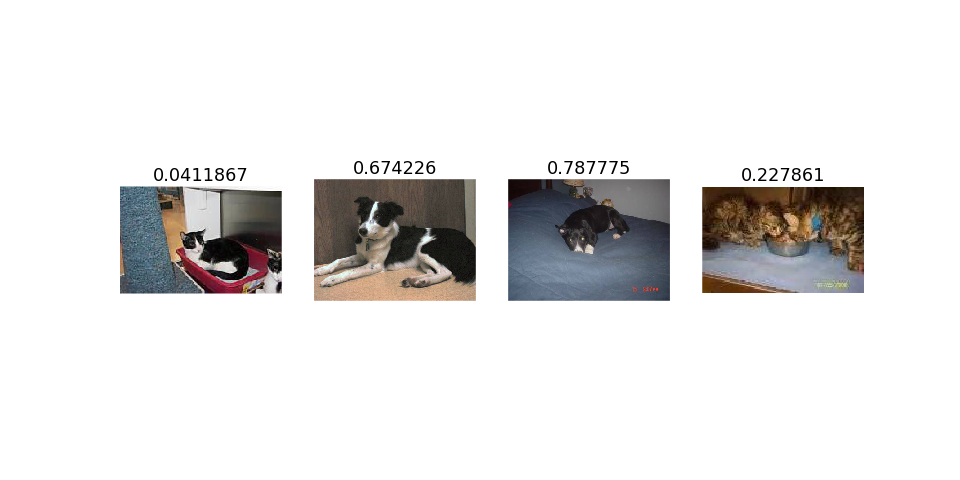

In [96]:
incorrect = np.where(preds != val_labels[:, 1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

<IPython.core.display.Javascript object>


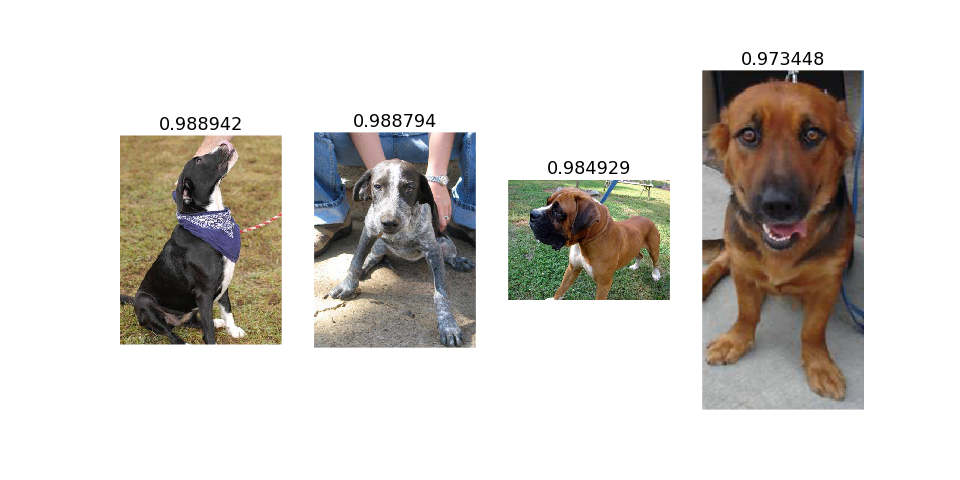

In [98]:
#correct dogs
correct_dogs = np.where((preds==1) & (preds == val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

<IPython.core.display.Javascript object>


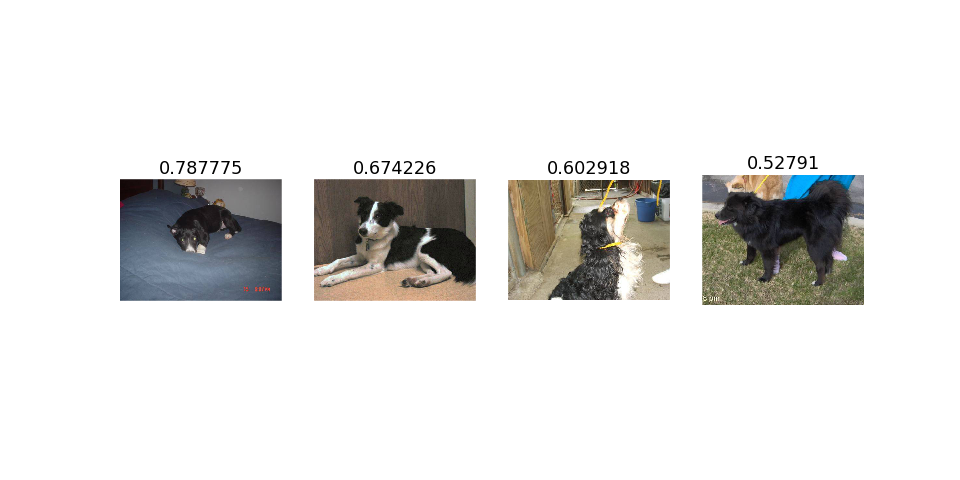

In [100]:
#Incorrect preds for cats which are most confident but wrong
incorrect_cats = np.where((preds==0) & (preds != val_labels[:, 1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

<IPython.core.display.Javascript object>


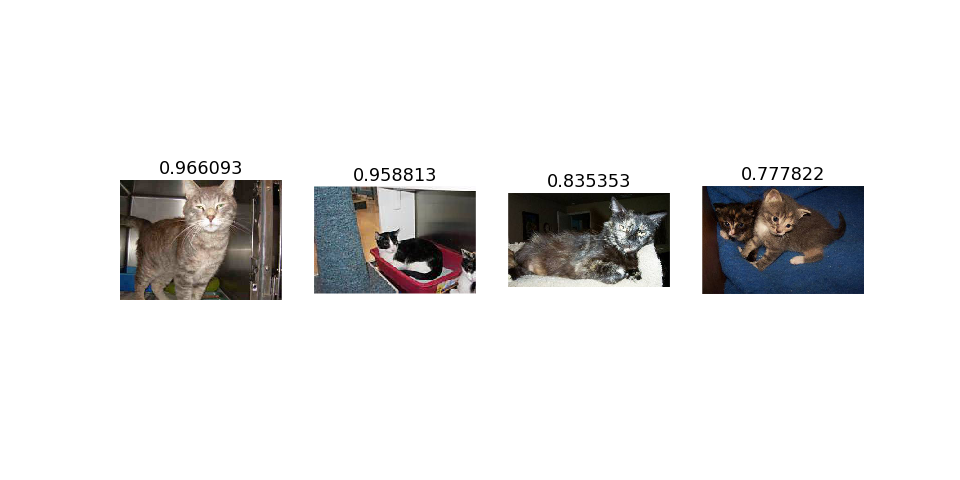

In [103]:
#Most incorrect dogs
incorrect_dogs = np.where((preds == 1) & (val_labels[:,1] != preds))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs) != 0:
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1- probs[incorrect_dogs][most_incorrect_dogs])
else:
    print("There is no incorrect dogs")

<IPython.core.display.Javascript object>


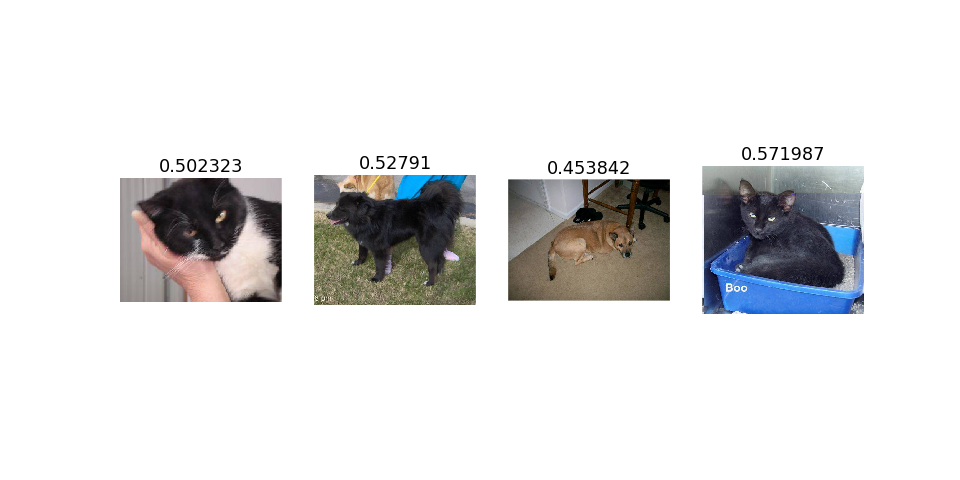

In [105]:
#The most uncertain labels (probability close to 0.5)
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

<IPython.core.display.Javascript object>


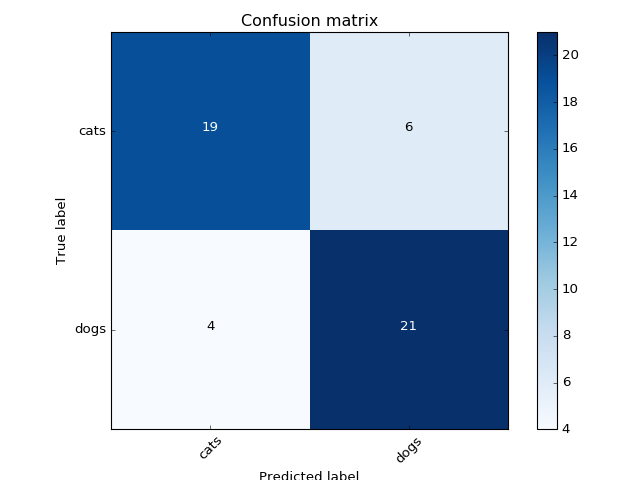

[[19  6]
 [ 4 21]]


In [106]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

In [107]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [108]:
#remove the last layer
model.pop()

In [109]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [110]:
for layer in model.layers:
    layer.trainable = False

In [111]:
model.add(Dense(2, activation='softmax'))

In [112]:
??vgg.finetune

In [118]:
#Now we will compile our revised model and set up our batches to use the pre processed images,
# we will shuffle training batches to add more randomness when running epoch

gen = image.ImageDataGenerator()
batches = gen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [122]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch,
                       validation_data=val_batches, nb_val_samples=val_batches.N)

In [123]:
opt = RMSprop(lr=0.01)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [124]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
200/200 [==============================] - 1247s - loss: 7.6931 - acc: 0.5150 - val_loss: 8.0590 - val_acc: 0.5000

In [125]:
model.save_weights(model_path+'finetune1.h5')
model.load_weights(model_path+'finetune1.h5')

In [126]:
model.evaluate(val_data, val_labels)

32/50 [==================>...........] - ETA: 85s50/50 [==============================] - 222s    


[8.0590478944778443, 0.5]

In [127]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)
probs[:8]

50/50 [==============================] - 217s     


array([[  1.5042e-25,   1.0000e+00],
       [  5.6195e-35,   1.0000e+00],
       [  2.4126e-35,   1.0000e+00],
       [  0.0000e+00,   1.0000e+00],
       [  1.4484e-32,   1.0000e+00],
       [  0.0000e+00,   1.0000e+00],
       [  2.0543e-36,   1.0000e+00],
       [  0.0000e+00,   1.0000e+00]], dtype=float32)

In [130]:
cm = confusion_matrix(val_classes, preds)

<IPython.core.display.Javascript object>


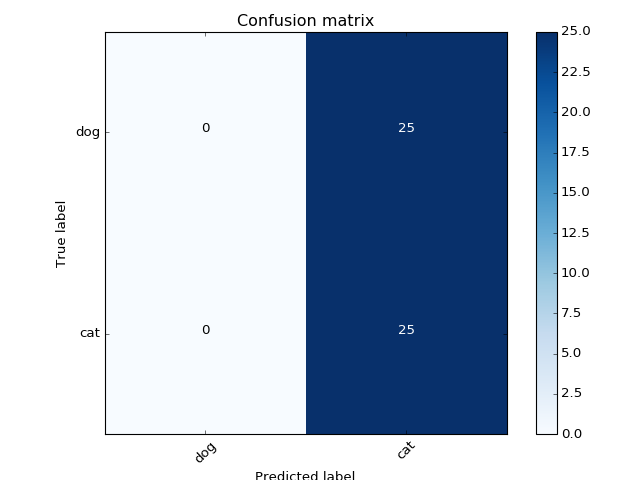

[[ 0 25]
 [ 0 25]]


In [132]:
plot_confusion_matrix(cm, {'cat': 0, 'dog': 1})

In [133]:
#sympy lets us use symbolic differentiation in python
import sympy as sp

#we have to define our variables
x = sp.var('x')
pow(2*x, 2).diff()

8*x

In [134]:
layers = model.layers
#get the index of first dense layer
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]
#set this and any other layer after that to trainable
for layer in layers[first_dense_idx:]:
    layer.trainable = True

In [135]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
200/200 [==============================] - 1646s - loss: 7.6561 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000

In [136]:
model.save_weights(model_path+'finetune.h5')

In [137]:
#Also sometime training few conv layer also improve slight performance and doesn't hurt tryi
for layer in layers[12:]:
    layer.trainable = True
K.set_value(opt.lr, 0.001)

In [139]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
200/200 [==============================] - 1414s - loss: 7.6561 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000

In [140]:
model.save_weights(model_path+'finetune3.h5')

In [142]:
model.load_weights(model_path+'finetune3.h5')
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.N)

Found 50 images belonging to 2 classes.


[8.0590477418899535, 0.5]